### GWR and MGWR example
***
This is a basic example notebook demostrate  how to calibrate a GWR or an MGWR model.

#### Installation

In case you may need to install the `mgwr` package:


`pip install mgwr`

In [1]:
#pip install mgwr

Load packages

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import libpysal as ps 
from libpysal.weights import Queen
from esda.moran import Moran

#MGWR functions
from mgwr.gwr import GWR,MGWR
from mgwr.sel_bw import Sel_BW

Load voting dataset

In [3]:
voting = pd.read_csv('https://raw.github.com/Ziqi-Li/gis5122/master/data/voting_2021.csv')

voting[['median_income']] = voting[['median_income']]/10000

In [4]:
shp = gpd.read_file("https://raw.github.com/Ziqi-Li/gis5122/master/data/us_counties.geojson")

In [5]:
#Merge the shapefile with the voting data by the common county_id
shp_voting = shp.merge(voting, on ="county_id")

#Dissolve the counties to obtain boundary of states, used for mapping
state = shp_voting.dissolve(by='STATEFP').geometry.boundary

In [6]:
variable_names = ['sex_ratio', 'pct_black', 'pct_hisp',
                  'pct_bach', 'median_income','ln_pop_den']


y = shp_voting[['new_pct_dem']].values

X = shp_voting[variable_names].values

Often in GWR or MGWR, we suggest to standardize both the independent and the dependent variables. 

By standardizing, here it means we substract the mean and divided by the standardization.

The benefit of this approach is that the coefficients obtained become "unit-free," allowing for comparison of variable importance across variables and locations.

You can also unstandardize the coefficients by following some simple maths (ask chatGPT)

In [7]:
X = (X - X.mean(axis=0))/X.std(axis=0)
y = (y - y.mean(axis=0))/y.std(axis=0)

We need the coordinates to put into GWR.

Make sure you are using projected coordinates.

In [8]:
coords = shp_voting[['proj_X', 'proj_Y']].values

#### Fit a GWR model in two steps
- Select the optimal bandwidths
- Use the optimal bandwidth to fit the GWR model
***
The default kernel is adaptive (# of nearest neighbors) bisquare.

In [9]:
%%time

gwr_selector = Sel_BW(coords, y, X,)

gwr_bw = gwr_selector.search(verbose=True,criterion='AICc')

print("Selected optimal bandwidth is:", gwr_bw)

Bandwidth:  1221.0 , score:  4033.85
Bandwidth:  1941.0 , score:  4597.80
Bandwidth:  775.0 , score:  3521.60
Bandwidth:  500.0 , score:  3095.52
Bandwidth:  329.0 , score:  2746.91
Bandwidth:  224.0 , score:  2469.38
Bandwidth:  159.0 , score:  2310.58
Bandwidth:  119.0 , score:  2245.74
Bandwidth:  94.0 , score:  2225.30
Bandwidth:  79.0 , score:  2232.10
Bandwidth:  104.0 , score:  2230.35
Bandwidth:  89.0 , score:  2222.88
Bandwidth:  85.0 , score:  2223.03
Bandwidth:  91.0 , score:  2223.30
Bandwidth:  87.0 , score:  2225.73
Selected optimal bandwidth is: 89.0
CPU times: user 1.73 s, sys: 461 ms, total: 2.19 s
Wall time: 5.35 s


The algorithm uses a optimization stragety to find the optimal bandwidth that gives the best score, in this case, the lowest AICc.

Fit the model using the optimal bw

In [10]:
gwr_results = GWR(coords, y, X, bw=gwr_bw,name_x=variable_names).fit()

Summary of GWR outputs. The outputs starts with an OLS model, then followed by GWR results.

In [11]:
gwr_results.summary()

Model type                                                         Gaussian
Number of observations:                                                3108
Number of covariates:                                                     7

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                           1209.887
Log-likelihood:                                                   -2943.936
AIC:                                                               5901.873
AICc:                                                              5903.919
BIC:                                                             -23727.532
R2:                                                                   0.611
Adj. R2:                                                              0.610

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

The local estimates can be obtained from `gwr_results.params`, which returns you a n by (1+p) array where p is the number of predictors in the model plus the intercept.

In [12]:
variable_names

['sex_ratio',
 'pct_black',
 'pct_hisp',
 'pct_bach',
 'median_income',
 'ln_pop_den']

In [13]:
gwr_results.params[:,4] #this will give you location-specific coefficient for pct_bach

array([ 0.5650606 ,  0.61548093,  0.42173768, ..., -0.08772565,
        0.75517883,  0.39387276])

Text(0.5, 1.0, 'Coefficients of pct_bach')

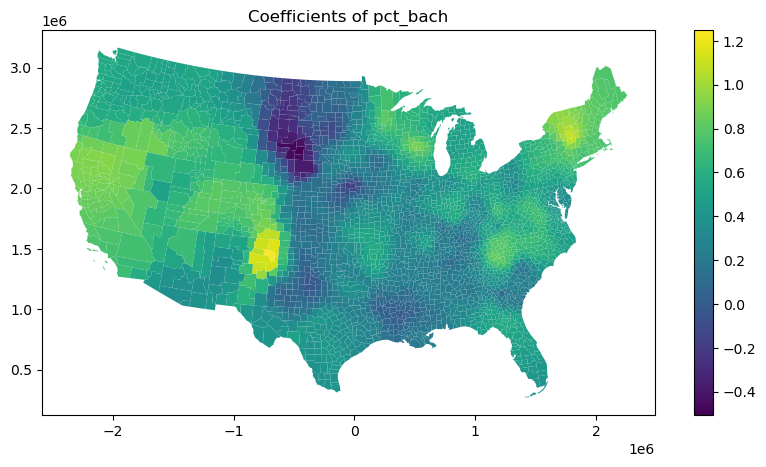

In [14]:
from matplotlib import colors

ax = shp_voting.plot(column=gwr_results.params[:,4],figsize=(10,5),legend=True, 
                     linewidth=0.0,aspect=1)

plt.title("Coefficients of " + variable_names[3] ,fontsize=12)

Write some mapping codes to visualize the parameter estimate surfaces altogether. We need to join the GWR result with the county GeoDataFrame.

In [15]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mgwr.utils import shift_colormap,truncate_colormap
from matplotlib import cm,colors

def param_plots(result, gdf, names=[], filter_t=False,figsize=(10, 10)):
    
    #Size of the plot. Here we have a 2 by 2 layout.
    k = gwr_results.k
    
    fig, axs = plt.subplots(int(k/2)+1, 2, figsize=figsize)
    axs = axs.ravel()
    
    #The max and min values of the color bar.
    vmin = -0.8
    vmax = 0.8
    
    cmap = cm.get_cmap("bwr_r")
    norm = colors.BoundaryNorm(np.arange(-0.8,0.9,0.1),ncolors=256)
    
    for j in range(k):
        
        pd.concat([gdf,pd.DataFrame(np.hstack([result.params,result.bse]))],axis=1).plot(ax=axs[j],column=j,vmin=vmin,vmax=vmax,
                                                                                         cmap=cmap,norm=norm,linewidth=0.1,edgecolor='white',aspect=1)
        axs[j].set_title("Parameter estimates of \n" + names[j],fontsize=10)
        
        if filter_t:
            rslt_filtered_t = result.filter_tvals()
            if (rslt_filtered_t[:,j] == 0).any():
                gdf[rslt_filtered_t[:,j] == 0].plot(color='lightgrey', ax=axs[j],linewidth=0.1,edgecolor='white',aspect=1)
        
        plt.axis('off')
    
    fig = axs[j].get_figure()
    cax = fig.add_axes([0.99, 0.2, 0.025, 0.6])
    sm = plt.cm.ScalarMappable(cmap=cmap,norm=norm)
    # fake up the array of the scalar mappable. Urgh...
    sm._A = []
    fig.colorbar(sm, cax=cax)

#### Here are the maps of parameter estimates obtained from GWR. Each represent the spatial relationship between each predictor and PctBach.

- Positive (negative) relationships are shown in red (blue).
- Stronger (weaker) relationship has a darker (lighter) color.

/var/folders/mp/9px298sd6vs8xccb_3sql0dr0000gp/T/ipykernel_6646/1374554983.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap("bwr_r")


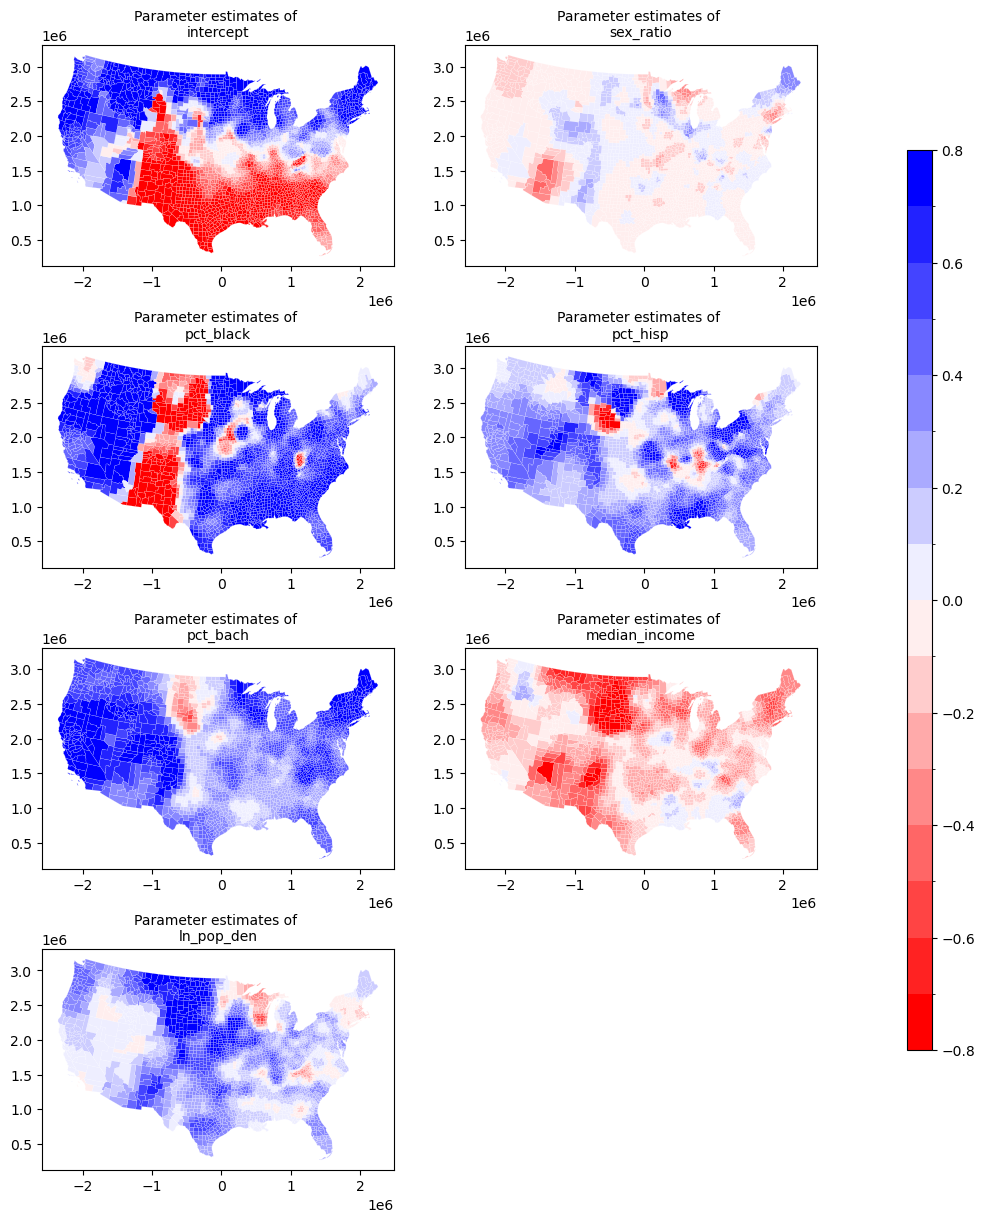

In [16]:
param_plots(gwr_results, shp_voting, names=['intercept'] + variable_names,figsize = (10,15))

Now lets checkout the residuals of from the GWR model.

In [17]:
#Here we use the Queen contiguity
w = Queen.from_dataframe(shp_voting)

#row standardization
w.transform = 'R'

residual_moran = Moran(gwr_results.resid_response.reshape(-1), w)
residual_moran.I

('WARNING: ', 2443, ' is an island (no neighbors)')
('WARNING: ', 2703, ' is an island (no neighbors)')


/var/folders/mp/9px298sd6vs8xccb_3sql0dr0000gp/T/ipykernel_6646/2963299590.py:2: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(shp_voting)
/Users/ziqili/anaconda3/lib/python3.11/site-packages/libpysal/weights/contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
 There are 2 islands with ids: 2443, 2703.
  W.__init__(self, neighbors, ids=ids, **kw)


0.11410885823498455

Often, we observe that the residuals from the GWR model have much lower Moran's I values, indicating that spatial structure has been accounted for. The local intercept serves as an intrinsic contextual effect, indicating, for example, how much influence can be attributed to the "location" alone.



### GWR inference

Local coefficient significance

#### Here are the maps of **SIGNIFICANT (p<0.05)** parameter estimates. The significance test has been adjusted to account for the multiple testing issue (Bonferroni). 

Insinificant parameters are masked out in grey. 

This is done by the `result.filter_tvals()` in the `param_plots()` function.


/var/folders/mp/9px298sd6vs8xccb_3sql0dr0000gp/T/ipykernel_6646/1374554983.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap("bwr_r")


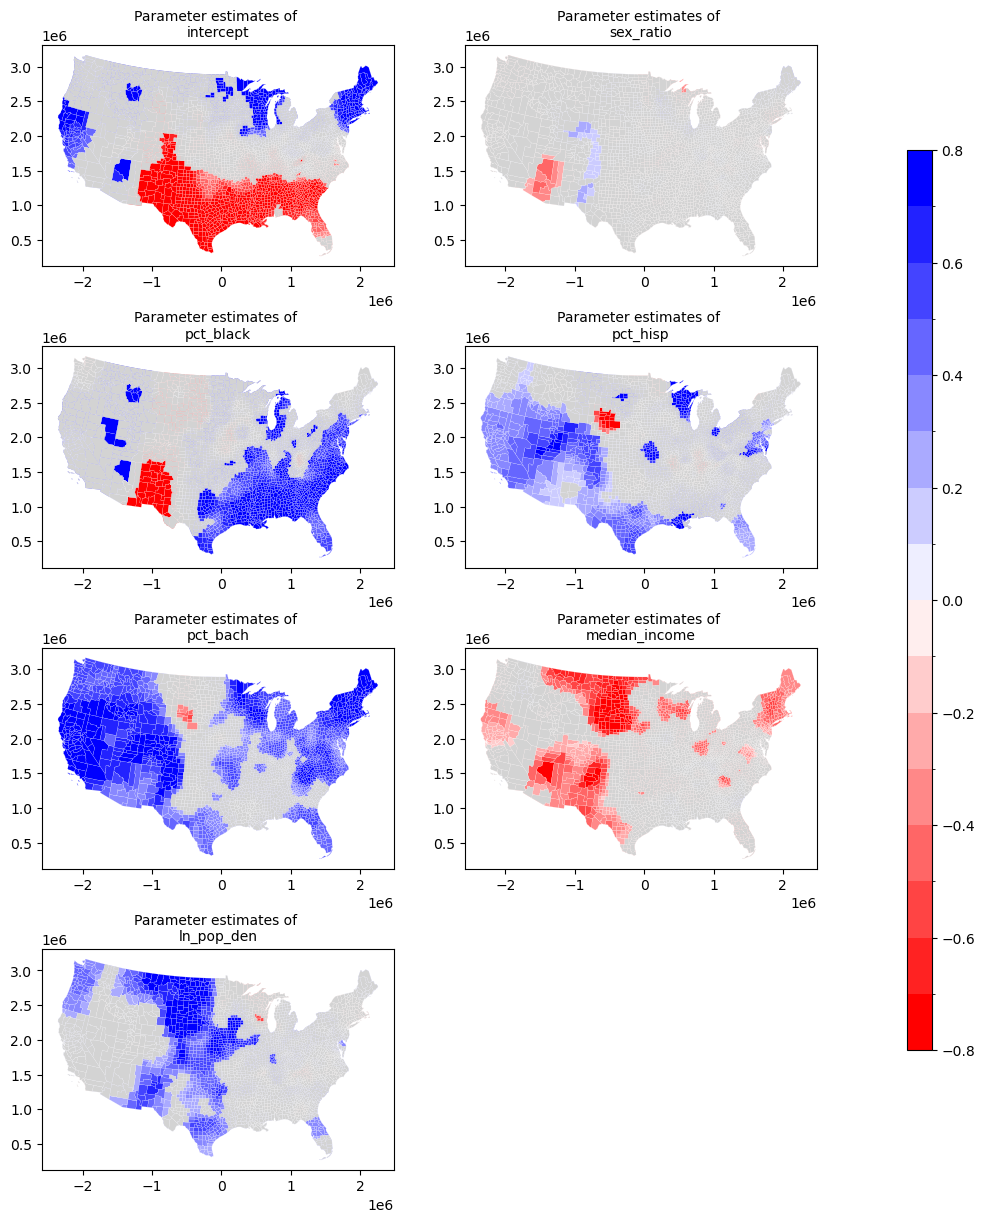

In [18]:
param_plots(gwr_results, shp_voting, names=['intercept'] + variable_names,figsize = (10,15), filter_t=True)

We find after we adjust the maps for both p-values and multiple testing, many of the patterns go away (are not significant)

#### Fit an MGWR model in two steps
- Search for the optimal bandwidths
- Use the optimal bandwidths to fit the MGWR model
***

**Note**: MGWR can be VERY slow when the data is beyond 3,000 records. 

The `%%time` cell magic can record the time taken for the cell to finish.

In [19]:
%%time
mgwr_selector = Sel_BW(coords, y, X,multi=True)
mgwr_bw = mgwr_selector.search(verbose=True)

print("Selected optimal bandwidth is:", gwr_bw)

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Current iteration: 1 ,SOC: 0.0054039
Bandwidths: 44.0, 173.0, 44.0, 44.0, 77.0, 46.0, 46.0
Current iteration: 2 ,SOC: 0.0025988
Bandwidths: 44.0, 445.0, 44.0, 54.0, 86.0, 44.0, 52.0
Current iteration: 3 ,SOC: 0.0017628
Bandwidths: 44.0, 707.0, 44.0, 77.0, 92.0, 44.0, 77.0
Current iteration: 4 ,SOC: 0.0014031
Bandwidths: 44.0, 1269.0, 44.0, 104.0, 100.0, 44.0, 113.0
Current iteration: 5 ,SOC: 0.0011663
Bandwidths: 44.0, 1397.0, 44.0, 131.0, 117.0, 44.0, 131.0
Current iteration: 6 ,SOC: 0.0010009
Bandwidths: 44.0, 1473.0, 44.0, 160.0, 117.0, 44.0, 154.0
Current iteration: 7 ,SOC: 0.0009015
Bandwidths: 44.0, 1585.0, 44.0, 225.0, 127.0, 44.0, 161.0
Current iteration: 8 ,SOC: 0.0007707
Bandwidths: 44.0, 1677.0, 44.0, 276.0, 140.0, 44.0, 171.0
Current iteration: 9 ,SOC: 0.0006461
Bandwidths: 44.0, 1677.0, 44.0, 309.0, 153.0, 44.0, 190.0
Current iteration: 10 ,SOC: 0.0005308
Bandwidths: 44.0, 1677.0, 44.0, 349.0, 155.0, 44.0, 194.0
Current iteration: 11 ,SOC: 0.0004407
Bandwidths: 44.0, 1677.

In [20]:
%%time

mgwr_results = MGWR(coords, y, X, selector=mgwr_selector,name_x=variable_names).fit()

Inference:   0%|          | 0/12 [00:00<?, ?it/s]

CPU times: user 604 ms, sys: 183 ms, total: 787 ms
Wall time: 6min 13s


MGWR summary file, that has OLS first then MGWR.

In [21]:
mgwr_results.summary()

Model type                                                         Gaussian
Number of observations:                                                3108
Number of covariates:                                                     7

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                           1209.887
Log-likelihood:                                                   -2943.936
AIC:                                                               5901.873
AICc:                                                              5903.919
BIC:                                                             -23727.532
R2:                                                                   0.611
Adj. R2:                                                              0.610

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

In [22]:
#Here we use the Queen contiguity
w = Queen.from_dataframe(shp_voting)

#row standardization
w.transform = 'R'

residual_moran = Moran(mgwr_results.resid_response.reshape(-1), w)
residual_moran.I

('WARNING: ', 2443, ' is an island (no neighbors)')

/var/folders/mp/9px298sd6vs8xccb_3sql0dr0000gp/T/ipykernel_6646/3541487640.py:2: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(shp_voting)
/Users/ziqili/anaconda3/lib/python3.11/site-packages/libpysal/weights/contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
 There are 2 islands with ids: 2443, 2703.
  W.__init__(self, neighbors, ids=ids, **kw)



('WARNING: ', 2703, ' is an island (no neighbors)')


0.01908323799838433

Moran's I is reduced to a minimal level.

/var/folders/mp/9px298sd6vs8xccb_3sql0dr0000gp/T/ipykernel_6646/1374554983.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap("bwr_r")


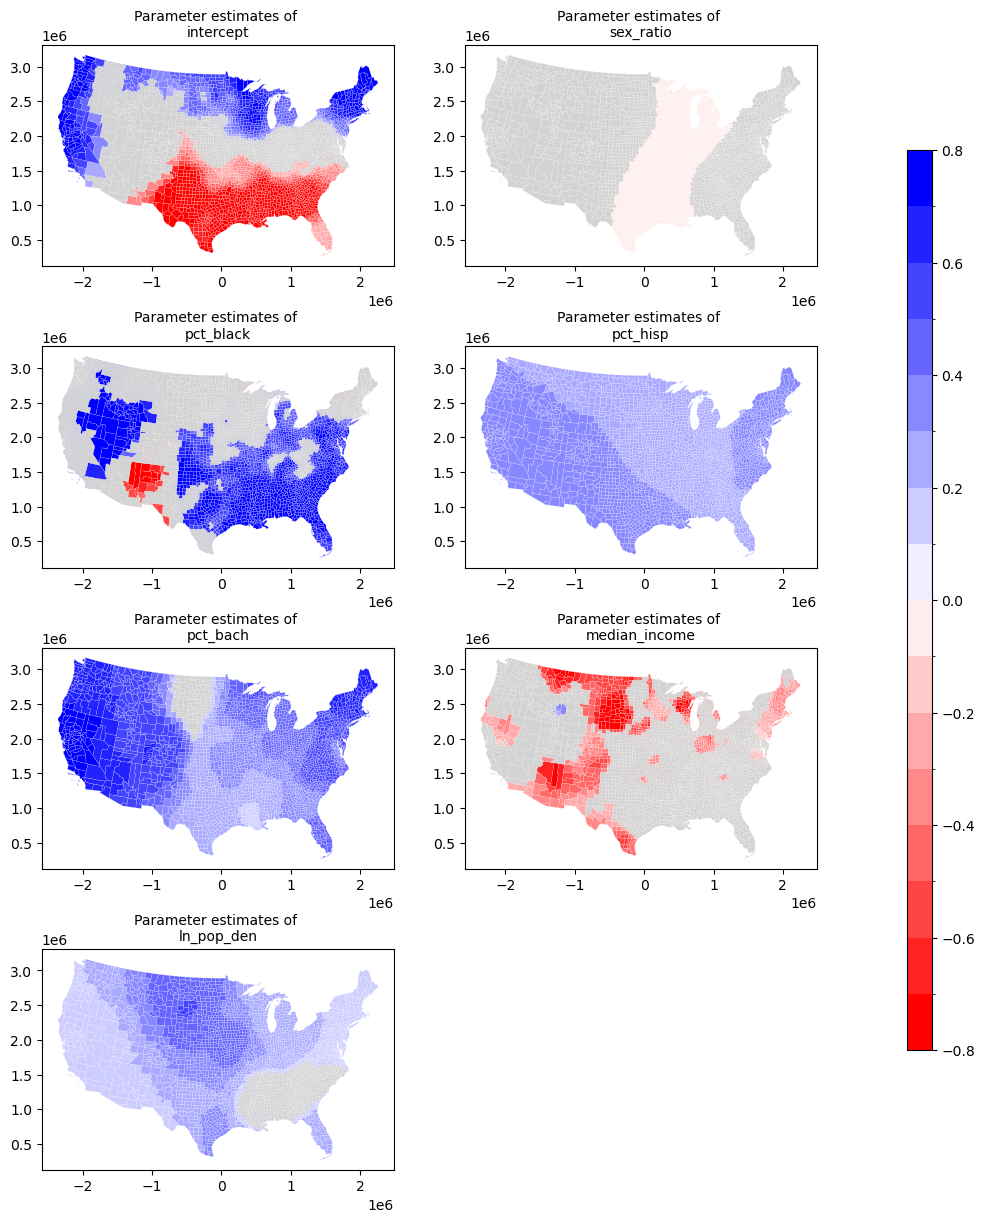

In [23]:
param_plots(mgwr_results, shp_voting, names=['intercept'] + variable_names,figsize = (10,15), filter_t=True)

We can see that the relationships will vary at different spatial scales.

### OLS vs. GWR vs. MGWR

From the comparison, we can clearly see an advantage of MGWR over GWR by allowing the bandwidth to vary across covariates.

| Metric    | OLS    | GWR   | MGWR   |
| -----------  | ----------- | ----------- | ----------- |
| R2     | 0.609       | 0.922        | 0.928      |
| AICc    | 5903.9        | 2222.9        | 1748.2      |
| Moran's I of residuals    | 0.60      | 0.11       | 0.019       |
